In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import lightgbm as lgb
from lightgbm.callback import log_evaluation, early_stopping

from isic_helper import DotDict
from isic_helper import get_folds
from isic_helper import compute_auc, compute_pauc

pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "lgb_v1"

In [3]:
INPUT_PATH = Path("../input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False)
test_metadata = pd.read_csv(INPUT_PATH / "test-metadata.csv")

folds_df = get_folds()
train_metadata = train_metadata.merge(folds_df, on=["isic_id", "patient_id"], how="inner")
print(f"Train data size: {train_metadata.shape}")
print(f"Test data size: {test_metadata.shape}")

Train data size: (401059, 57)
Test data size: (3, 44)


In [4]:
# train_metadata["target"].value_counts(normalize=True)

# train_metadata["test"] = train_metadata["clin_size_long_diam_mm"] - train_metadata["tbp_lv_minorAxisMM"]

# train_metadata.groupby("target")["test"].mean()

# level_col = "patient_id"
# group_cols = ["tbp_lv_location", "anatom_site_general"]
# value_col = "clin_size_long_diam_mm"
# stats = ["mean"]

# tmp1 = train_metadata.groupby([level_col] + group_cols)[value_col].agg(stats).reset_index()

# tmp2 = tmp1.groupby(group_cols)[stats].agg(["mean"])

# tmp2.columns

# tmp2

In [5]:
# def stat_features(df, level_col, group_cols, value_col, stats):
#     tmp1 = df.groupby([level_col] + group_cols)[value_col].agg(stats).reset_index()
#     tmp2 = tmp1.groupby(group_cols)[stats]
#     tmp.reset_index(inplace=True)
#     df = df.merge(tmp, on=group_cols, how="left")
#     df[f"{value_col}_mean_diff"] = df[value_col] - df[f"{value_col}_mean"]
    
#     new_stat_num_cols = [f"{value_col}_{stat}" for stat in stats] + [f"{value_col}_mean_diff"]
#     return df, new_stat_num_cols

In [6]:
def stat_features(df, group_cols, value_col, stats):
    tmp = df.groupby(group_cols)[value_col].agg(stats)
    tmp.columns = [f"{value_col}_{stat}" for stat in stats]
    tmp.reset_index(inplace=True)
    df = df.merge(tmp, on=group_cols, how="left")
    df[f"{value_col}_mean_diff"] = df[value_col] - df[f"{value_col}_mean"]
    
    new_stat_num_cols = (
#         [f"{value_col}_{stat}" for stat in stats] 
#         + 
        [f"{value_col}_mean_diff"]
    )
    return df, new_stat_num_cols

In [7]:
def feature_engineering(df):
    new_num_cols = []
    new_cat_cols = []
    
    df["max_minus_min_lesion_size"] = df["clin_size_long_diam_mm"] - df["tbp_lv_minorAxisMM"]
    df["tbp_lv_A_diff"] =  df["tbp_lv_Aext"] - df["tbp_lv_A"]
    df, new_stat_num_cols = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_A_diff", ["mean", "std"])
    new_num_cols += new_stat_num_cols
    df["tbp_lv_B_diff"] =  df["tbp_lv_Bext"] - df["tbp_lv_B"]
    df, new_stat_num_cols = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_B_diff", ["mean", "std"])
    new_num_cols += new_stat_num_cols
#     df["tbp_lv_C_diff"] =  df["tbp_lv_Cext"] - df["tbp_lv_C"]
#     df, new_stat_num_cols = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_C_diff", ["mean", "std"])
#     new_num_cols += new_stat_num_cols
    
#     df["normalized_lesion_diameter"]
#     df["lesion_distance"] = np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
#     df["detailed_site"] = df["tbp_lv_location_simple"].str.cat(df["anatom_site_general"], sep="|")
    
#     df["lesion_size_ratio"]              = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
#     df["hue_contrast"]                   = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
#     df["normalized_lesion_size"]         = df["clin_size_long_diam_mm"] / df["age_approx"]
#     df["overall_color_difference"]       = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    
#     patient_num_images = df.groupby("patient_id", as_index=False)["isic_id"].count().rename(columns={"isic_id": "num_images"})
#     df = df.merge(patient_num_images, on="patient_id", how="left")

    new_num_cols += [
        "max_minus_min_lesion_size"
    ]
    
    new_cat_cols += [
#         "detailed_site"
    ]
    
    
    return df, new_num_cols, new_cat_cols

train_metadata, new_num_cols, new_cat_cols = feature_engineering(train_metadata.copy())
test_metadata, new_num_cols, new_cat_cols = feature_engineering(test_metadata.copy())

In [8]:
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,final_target,fold,max_minus_min_lesion_size,tbp_lv_A_diff,tbp_lv_A_diff_mean,tbp_lv_A_diff_std,tbp_lv_A_diff_mean_diff,tbp_lv_B_diff,tbp_lv_B_diff_mean,tbp_lv_B_diff_std,tbp_lv_B_diff_mean_diff
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,0,4,1.496984,-3.982447,-3.685802,1.627868,-0.296645,-2.967674,-1.073571,2.019676,-1.894103
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0,1,0.278082,-6.347830,-3.938782,2.518329,-2.409048,-1.781710,-1.165544,1.575264,-0.616166
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0,5,2.205095,-5.447660,-4.309035,1.344834,-1.138625,-4.485050,-3.577588,1.041751,-0.907462
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,0,2,0.738672,-2.077572,-6.487934,4.211741,4.410363,-0.326788,-0.588423,2.080968,0.261635
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,0,1,1.800084,-4.668050,-5.667873,2.310629,0.999823,-0.754440,-2.403241,2.177909,1.648801


In [9]:
# train_metadata.groupby("target")["tbp_lv_C_diff_mean_diff"].mean()

In [10]:
def preprocess(df):
#     df["age_approx"] = np.log1p(df["age_approx"])
#     df["clin_size_long_diam_mm"] = np.log1p(df["clin_size_long_diam_mm"])
    return df

train_metadata = preprocess(train_metadata)
test_metadata = preprocess(test_metadata)

In [11]:
id_column = "isic_id"
target_column = "final_target"
group_column = "patient_id"
# drop_features = ["image_type", "attribution", "copyright_license", "sex"] + train_metadata.columns[~np.in1d(train_metadata.columns, test_metadata.columns)].tolist() # target column removed
# ord_categorical_features = ["anatom_site_general", "tbp_tile_type", "tbp_lv_location_simple", "tbp_lv_location"] + new_cat_cols
# ohe_categorical_features = []
# numerical_features = train_metadata.columns[~np.in1d(train_metadata.columns, 
#                                                      [id_column] + [group_column] + ord_categorical_features + ohe_categorical_features + drop_features)]

In [12]:
ord_categorical_features = ["tbp_tile_type", "tbp_lv_location_simple", "anatom_site_general"]
ohe_categorical_features = []
numerical_features = ["age_approx", "clin_size_long_diam_mm", "tbp_lv_minorAxisMM", 
                      "tbp_lv_A", "tbp_lv_Aext",
                      "tbp_lv_B", "tbp_lv_Bext",
#                       "tbp_lv_C", "tbp_lv_Cext",
                      "tbp_lv_H", "tbp_lv_Hext",
                     ] + new_num_cols

In [13]:
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_categorical_features,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False),
            ohe_categorical_features
        )
    ],
    verbose_feature_names_out=False,

)
mixed_encoded_preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('numerical', 'passthrough',
                                 ['age_approx', 'clin_size_long_diam_mm',
                                  'tbp_lv_minorAxisMM', 'tbp_lv_A',
                                  'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
                                  'tbp_lv_H', 'tbp_lv_Hext',
                                  'tbp_lv_A_diff_mean_diff',
                                  'tbp_lv_B_diff_mean_diff',
                                  'max_minus_min_lesion_size']),
                                ('ord_categorical',
                                 OrdinalEncoder(dtype=<class 'int'>,
                                                encoded_missing_value=-1,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-2),
                                 ['tbp_tile_type', 'tbp_lv_location_simple',
                                  'anatom_site_general']),
                                ('ohe_categorical',
                                 OneHotEncoder(sparse_output=False), [])],
                  verbose_feature_names_out=False)

In [14]:
with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(mixed_encoded_preprocessor, f)

In [15]:
train_ids = train_metadata[id_column]
groups = train_metadata[group_column]
folds = train_metadata["fold"]

enc = mixed_encoded_preprocessor.fit(train_metadata)
X_train = enc.transform(train_metadata)
y_train = train_metadata[target_column]

In [16]:
X_train.head()

,age_approx,clin_size_long_diam_mm,tbp_lv_minorAxisMM,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_H,tbp_lv_Hext,tbp_lv_A_diff_mean_diff,tbp_lv_B_diff_mean_diff,max_minus_min_lesion_size,tbp_tile_type,tbp_lv_location_simple,anatom_site_general
0,60.0,3.04,1.543016,20.244422,16.261975,26.922447,23.954773,53.058545,55.828924,-0.296645,-1.894103,1.496984,1,4,2
1,60.0,1.10,0.821918,31.712570,25.364740,26.331000,24.549290,39.702910,44.064040,-2.409048,-0.616166,0.278082,1,0,1
2,60.0,3.40,1.194905,22.575830,17.128170,37.970460,33.485410,59.265850,62.909730,-1.138625,-0.907462,2.205095,0,5,3
3,65.0,3.22,2.481328,14.242329,12.164757,21.448144,21.121356,56.414429,60.060388,4.410363,0.261635,0.738672,0,6,0
4,55.0,2.73,0.929916,24.725520,20.057470,26.464900,25.710460,46.946070,52.041180,0.999823,1.648801,1.800084,1,6,0


In [17]:
categorical_features = ord_categorical_features[:]
for ohe_col in ohe_categorical_features:
    categorical_features += [col for col in X_train.columns if col.startswith(ohe_col)]

In [18]:
columns_for_model = len(X_train.columns)
print(f"Total number of columns: {columns_for_model}")

Total number of columns: 15


In [19]:
def pauc_80(preds, data):
    score_value = compute_pauc(data.get_label(), preds, min_tpr=0.8)   
    return 'pauc_80', score_value, True

In [20]:
params = {
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 63,
    "learning_rate": 0.01,
    "bagging_freq": 5,
    "bagging_fraction": 0.6,
    "bagging_seed": cfg.seed,
    "feature_fraction": 0.3,
    "feature_fraction_seed": cfg.seed,
    "lambda_l1": 0.95,
    "lambda_l2": 0.95,
    "verbosity": -1
}
num_rounds = 2500
es_rounds = 200
log_rounds = 50

In [21]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.sort(folds.unique())
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
    print(f"Running fold: {fold}")
    dev_index = folds != fold
    val_index = folds == fold
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    lgb_dataset_dev = lgb.Dataset(X_dev, label=y_dev, categorical_feature=categorical_features, free_raw_data=False)
    lgb_dataset_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(
        params,
        lgb_dataset_dev,
        num_boost_round=num_rounds,
        valid_sets=[lgb_dataset_val],
        feval=pauc_80,
        callbacks=[early_stopping(stopping_rounds=es_rounds), log_evaluation(log_rounds)],
    )
    
    model.save_model(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    best_num_rounds[f"fold_{fold}"] = model.best_iteration
    val_scores = dict(model.best_score["valid_0"])
    
    val_auc_scores[f"fold_{fold}"] = val_scores["auc"]
    val_pauc_scores[f"fold_{fold}"] = val_scores["pauc_80"]
    
    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    oof_predictions[val_index] = val_preds
    print("\n")

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_preds_df.to_csv(f"oof_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(X_train.columns)

Running fold: 1
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 200 rounds
[50]	valid_0's auc: 0.923216	valid_0's pauc_80: 0.136057
[100]	valid_0's auc: 0.92245	valid_0's pauc_80: 0.134652
[150]	valid_0's auc: 0.9255	valid_0's pauc_80: 0.137637
[200]	valid_0's auc: 0.926688	valid_0's pauc_80: 0.138815
[250]	valid_0's auc: 0.930445	valid_0's pauc_80: 0.142525
[300]	valid_0's auc: 0.932093	valid_0's pauc_80: 0.144255
[350]	valid_0's auc: 0.93495	valid_0's pauc_80: 0.147021
[400]	valid_0's auc: 0.936391	valid_0's pauc_80: 0.148567
[450]	valid_0's auc: 0.936035	valid_0's pauc_80: 0.148193
[500]	valid_0's auc: 0.937134	valid_0's pauc_80: 0.149572
[550]	valid_0's auc: 0.937641	valid_0's pauc_80: 0.149986
[600]	valid_0's auc: 0.938169	valid_0's pauc_80: 0.150475
[650]	valid_0's auc: 0.9387	valid_0's pauc_80: 0.151056
[700]	valid_0's auc: 0.938734	valid_0's pauc_80: 0.151286
[750]	valid_0's auc: 0.938616

In [22]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.sort(folds.unique())
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
    print(f"Running fold: {fold}")
    dev_index = folds != fold
    val_index = folds == fold
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    lgb_dataset_dev = lgb.Dataset(X_dev, label=y_dev, categorical_feature=categorical_features, free_raw_data=False)
    lgb_dataset_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(
        params,
        lgb_dataset_dev,
        num_boost_round=num_rounds,
        valid_sets=[lgb_dataset_val],
        feval=pauc_80,
        callbacks=[early_stopping(stopping_rounds=es_rounds), log_evaluation(log_rounds)],
    )
    
    model.save_model(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    best_num_rounds[f"fold_{fold}"] = model.best_iteration
    val_scores = dict(model.best_score["valid_0"])
    
    val_auc_scores[f"fold_{fold}"] = val_scores["auc"]
    val_pauc_scores[f"fold_{fold}"] = val_scores["pauc_80"]
    
    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    oof_predictions[val_index] = val_preds
    print("\n")

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_preds_df.to_csv(f"oof_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(X_train.columns)

Running fold: 1
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 200 rounds
[50]	valid_0's auc: 0.923216	valid_0's pauc_80: 0.136057
[100]	valid_0's auc: 0.92245	valid_0's pauc_80: 0.134652
[150]	valid_0's auc: 0.9255	valid_0's pauc_80: 0.137637
[200]	valid_0's auc: 0.926688	valid_0's pauc_80: 0.138815
[250]	valid_0's auc: 0.930445	valid_0's pauc_80: 0.142525
[300]	valid_0's auc: 0.932093	valid_0's pauc_80: 0.144255
[350]	valid_0's auc: 0.93495	valid_0's pauc_80: 0.147021
[400]	valid_0's auc: 0.936391	valid_0's pauc_80: 0.148567
[450]	valid_0's auc: 0.936035	valid_0's pauc_80: 0.148193
[500]	valid_0's auc: 0.937134	valid_0's pauc_80: 0.149572
[550]	valid_0's auc: 0.937641	valid_0's pauc_80: 0.149986
[600]	valid_0's auc: 0.938169	valid_0's pauc_80: 0.150475
[650]	valid_0's auc: 0.9387	valid_0's pauc_80: 0.151056
[700]	valid_0's auc: 0.938734	valid_0's pauc_80: 0.151286
[750]	valid_0's auc: 0.938616

<Axes: >

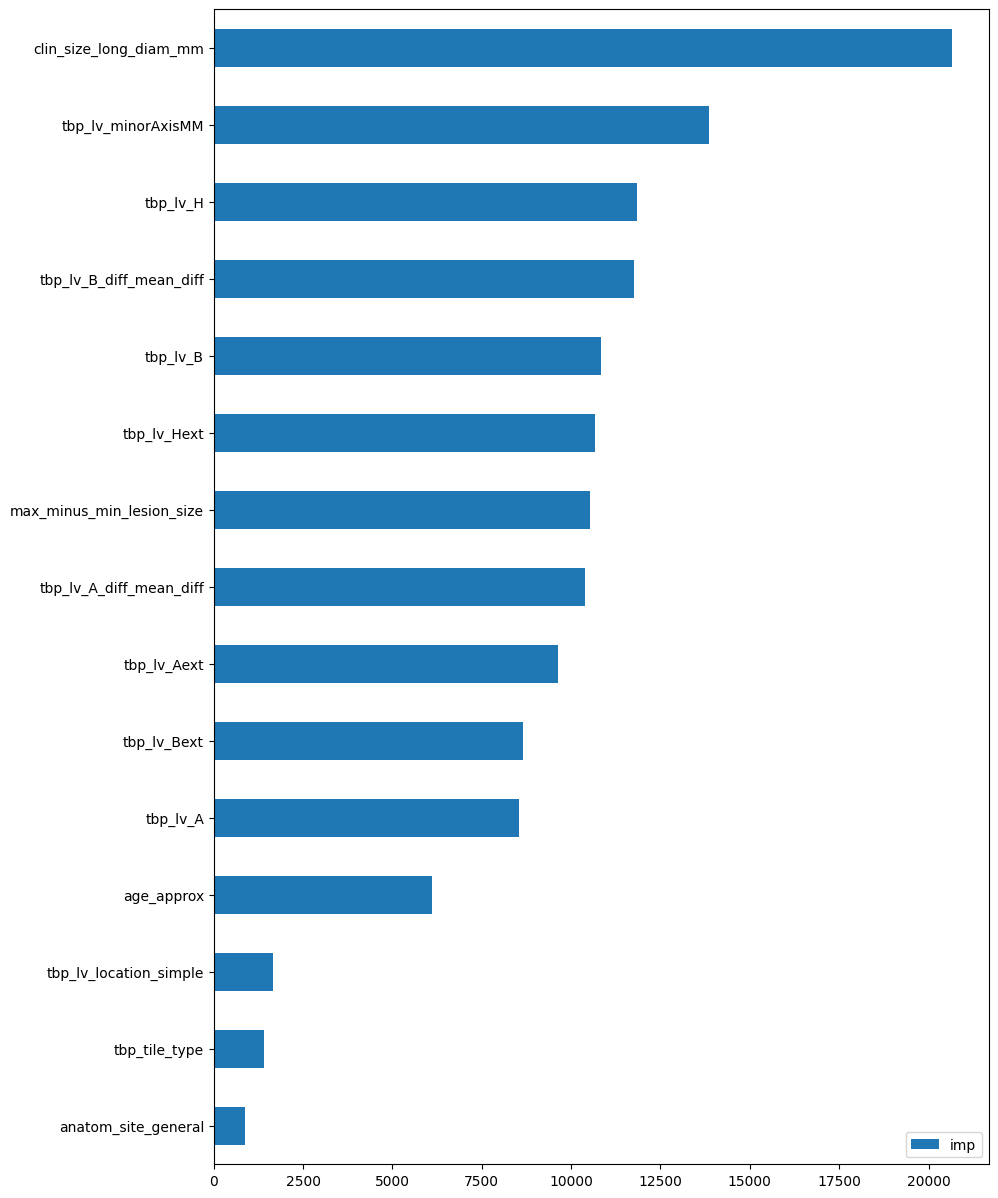

In [23]:
tmp = pd.DataFrame.from_dict(dict(zip(model.feature_name(), model.feature_importance(importance_type="gain"))), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
tmp.plot(kind="barh", figsize=(10, 15))

In [24]:
metadata = {
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg
}

with open("run_metadata.json", "w") as f:
    json.dump(metadata, f)